## 1D Advection PDE:

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1], \quad t > 0 $
## Initial Condition:
$ u(x, 0) = u_0(x) = 2\pi x \quad \text{for} \quad x \in [0, 1]$

## Without any BCs

dt/1 = dx/1 = du/0  , u=c; x-t=c1

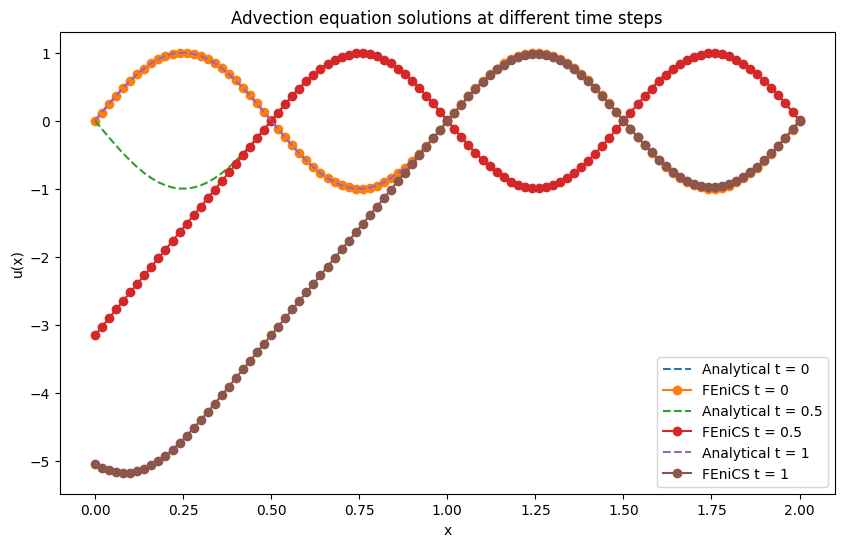

In [59]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total time
dt = 0.001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed (here 1)

# Step 1: Create a 1D mesh on the interval [0, 1] with 50 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, 2])

# Step 2: Define function space (Lagrange elements of degree 1 for linear basis functions)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition: u(x, 0) = (2*pi*x)
u_n = fem.Function(V)
u_n.interpolate(lambda x: np.sin(2 * np.pi * x[0]))

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using a backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# # Step 5: Weak form for the advection equation using a backward Euler method
# a = inner(u, v) * dx
# L = inner(u_n, v) * dx - dt * c * inner(grad(u_n)[0], v) * dx

# Step 5: Weak form for the advection equation using Crank-Nicolson method
# We use the average of the current and next time step terms (Crank-Nicolson scheme)
# a = inner(u, v) * dx + (dt * c / 2) * inner(grad(u)[0], v) * dx  # lhs
# L = inner(u_n, v) * dx - (dt * c / 2) * inner(grad(u_n)[0], v) * dx  # rhs

# Step 6: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L)

# Store solutions for desired time steps
times_to_store = [0,0.5,1]
stored_solutions = {}

for n in range(num_steps+1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store the solution at specific time steps
    current_time = (n + 0) * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0) \
            or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 7: Compare FEniCS solutions with analytical solutions at different time steps
# Get the coordinates of the mesh points (for FEniCS solution)
mesh_points = V.tabulate_dof_coordinates()[:, 0]

# Plot numerical and analytical solutions at different time steps
plt.figure(figsize=(10, 6))

for time in times_to_store:
    # Analytical solution at this time step
    u_analytical = np.sin(2 * np.pi * (mesh_points - c * time))

    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]

    # Plotting the solutions
    plt.plot(mesh_points, u_analytical, linestyle="dashed", label=f"Analytical t = {time}")
    plt.plot(mesh_points, u_fenics, marker='o', linestyle="solid", label=f"FEniCS t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()

## 1D Advection PDE:

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1], \quad t > 0 $
## Initial Condition:
$ u(x, 0) = u_0(x) = 2\pi x \quad \text{for} \quad x \in [0, 1]$

## With Boundary Condition:
$ u(0,t) = 0 \quad \forall t$

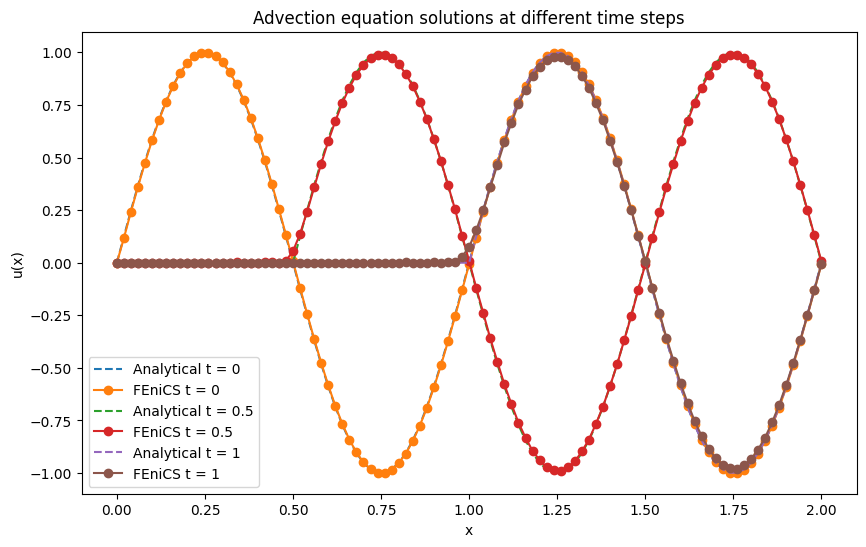

In [60]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total time
dt = 0.001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed (here 1)

# Step 1: Create a 1D mesh on the interval [0, 1] with 50 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, 2])

# Step 2: Define function space (Lagrange elements of degree 1 for linear basis functions)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition: u(x, 0) = (2*pi*x)
u_n = fem.Function(V)
u_n.interpolate(lambda x: np.sin(2 * np.pi * x[0]))

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using a backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# # Step 5: Weak form for the advection equation using a backward Euler method
# a = inner(u, v) * dx
# L = inner(u_n, v) * dx - dt * c * inner(grad(u_n)[0], v) * dx

# Step 5: Weak form for the advection equation using Crank-Nicolson method
# We use the average of the current and next time step terms (Crank-Nicolson scheme)
# a = inner(u, v) * dx + (dt * c / 2) * inner(grad(u)[0], v) * dx  # lhs
# L = inner(u_n, v) * dx - (dt * c / 2) * inner(grad(u_n)[0], v) * dx  # rhs

# Step 6: Define Dirichlet boundary condition u(0,t) = 0
def boundary_left(x):
    return np.isclose(x[0], 0.0)  # Mark the boundary at x=0
# boundary_left([0.0])  # x[0] = 0.0
# np.isclose(0.0, 0.0) -> True

u_D = fem.Function(V)  # Dirichlet condition is zero
bc = fem.dirichletbc(u_D, fem.locate_dofs_geometrical(V, boundary_left))

# Step 7: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L, bcs=[bc])  # Apply the boundary condition

# Store solutions for desired time steps
times_to_store = [0,0.5,1]
stored_solutions = {}

for n in range(num_steps+1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store the solution at specific time steps
    current_time = (n + 0) * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0) \
            or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 8: Compare FEniCS solutions with analytical solutions at different time steps
# Get the coordinates of the mesh points (for FEniCS solution)
mesh_points = V.tabulate_dof_coordinates()[:, 0]

# Plot numerical and analytical solutions at different time steps
plt.figure(figsize=(10, 6))

for time in times_to_store:
    # Analytical solution at this time step
    u_analytical = np.zeros_like(mesh_points)
    for i, x in enumerate(mesh_points):
        if x >= c * time:
            u_analytical[i] = np.sin(2 * np.pi * (x - c * time))
    # # Analytical solution at this time step
    # u_analytical = np.sin(2 * np.pi * (mesh_points - c * time))

    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]

    # Plotting the solutions
    plt.plot(mesh_points, u_analytical, linestyle="dashed", label=f"Analytical t = {time}")
    plt.plot(mesh_points, u_fenics, marker='o', linestyle="solid", label=f"FEniCS t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()

Error and convergence computation

In [61]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt


# function to solve the advection pde
def solve_advection(N=100, degree=1, dt=0.001, T=1.0, c=1.0):
    # Create a 1D mesh on the interval [0, 2] with N elements
    domain = mesh.create_interval(MPI.COMM_WORLD, N, [0, 2])

    # Define the function space
    V = fem.functionspace(domain, ("Lagrange", degree))

    # Initial condition: u(x, 0) = 2*pi*x
    u_n = fem.Function(V)
    u_n.interpolate(lambda x: np.exp(2 * np.pi * x[0]))

    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Weak form for the advection equation using a backward Euler method
    a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
    L = inner(u_n, v) * dx

    # Time-stepping loop
    u_new = fem.Function(V)  # Solution at the new time step
    problem = LinearProblem(a, L)

    # Store solutions at specific time steps (for comparison with exact solution)
    times_to_store = [1.0, 1.5, 2.0]
    stored_solutions = {}

    num_steps = int(T / dt)
    for n in range(num_steps + 1):
        # Solve the linear system for u at the new time step
        u_new = problem.solve()

        # Update the solution for the next time step
        u_n.x.array[:] = u_new.x.array[:]

        # Store the solution at specific time steps
        current_time = n * dt
        if np.isclose(current_time, 1.0) or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
            stored_solutions[current_time] = u_n.x.array.copy()

    return stored_solutions, V

In [62]:
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

# Mesh resolutions to test
Ns = [10, 20, 40, 80, 160, 200]
Es = np.zeros(len(Ns), dtype=np.float64)  # L2 errors
hs = np.zeros(len(Ns), dtype=np.float64)  # Mesh sizes

# Function to compute L2 error for each N
def compute_L2_error(V, u_fenics, time, c=1.0):
    mesh_points = V.tabulate_dof_coordinates()[:, 0]

    # Analytical solution at this time step
    u_analytical = np.exp(2 * np.pi * (mesh_points - c * time))
    
    # Compute the L2 error between the numerical and analytical solutions
    error = np.sqrt(np.sum((u_fenics - u_analytical) ** 2) * (1 / len(mesh_points)))
    return error

# Loop over mesh resolutions
for i, N in enumerate(Ns):
    # Solve the advection equation for each N
    stored_solutions, V = solve_advection(N=N, degree=1, dt=1/500, T=2.0, c=1.0)
    
    # Get the last solution (at t = 2.0) for error calculation
    u_fenics = stored_solutions[2.0]

    # Compute L2 error at final time t = 2.0
    Es[i] = compute_L2_error(V, u_fenics, time=2.0, c=1.0)

    # Mesh size h
    hs[i] = 1.0 / N
    
    # Print the error for each mesh resolution
    comm = V.mesh.comm
    if comm.rank == 0:
        print(f"h: {hs[i]:.2e}, L2 Error: {Es[i]:.2e}")

# Compute the convergence rates
rates = np.log(Es[1:] / Es[:-1]) / np.log(hs[1:] / hs[:-1])

# Print the convergence rates
if comm.rank == 0:
    print(f"Convergence rates: {rates}")

h: 1.00e-01, L2 Error: 8.93e+05
h: 5.00e-02, L2 Error: 9.45e+05
h: 2.50e-02, L2 Error: 9.51e+05
h: 1.25e-02, L2 Error: 9.48e+05
h: 6.25e-03, L2 Error: 9.45e+05
h: 5.00e-03, L2 Error: 9.45e+05
Convergence rates: [-0.08299193 -0.0090819   0.00448075  0.00456604  0.00341905]


Solving by SUPG

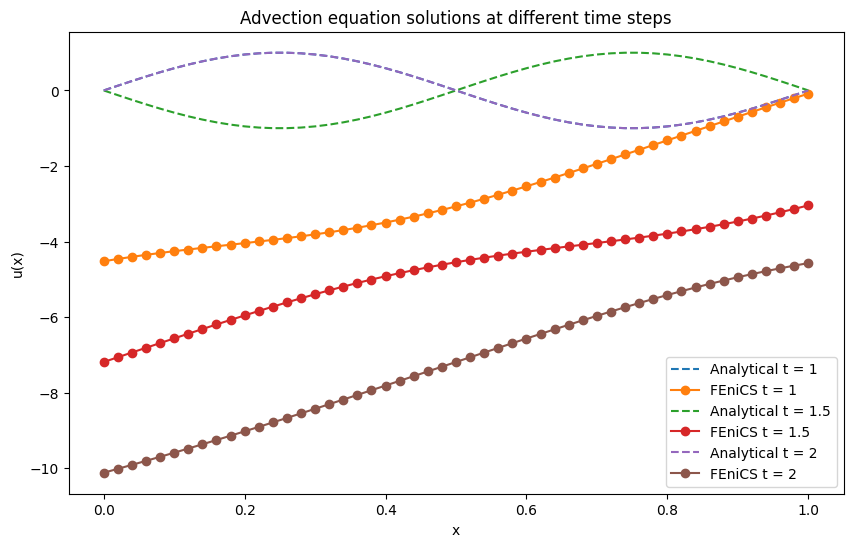

In [3]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx, CellDiameter, Constant
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt

# Parameters
T = 2.0  # Total time
dt = 0.01  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed (here 1)

# SUPG parameter (tau) - can be tuned by beta based on our problem
def compute_tau(beta, h, c):
    return beta * h / (2 * c)

# Step 1: Create a 1D mesh on the interval [0, 1] with 50 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 50, [0, 1])

# Step 2: Define function space (Lagrange elements of degree 1 for linear basis functions)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition: u(x, 0) = sin(2*pi*x)
u_n = fem.Function(V)
u_n.interpolate(lambda x: np.sin(2 * np.pi * x[0]))

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Mesh size and beta for computing tau (SUPG stabilization parameter)
# h = fem.Function(V).function_space.mesh.ufl_cell().degree
# h = CellDiameter(domain)
h = 1 / 50
# print(h)
# print(diameter)
beta = 0.01

# Step 5: Weak form for the advection equation using a backward Euler method with SUPG
tau = compute_tau(beta, h, c)  # Stabilization parameter tau
# print(tau)
# residual = (u - u_n) / dt + c * grad(u)[0]
# Stabilization term by taking test function as v + tau * c grad(v)[0] instead of v
stabilization_term = tau * c * inner(grad(v)[0], u) * dx + tau * c*c * dt * inner(grad(v)[0], grad(u)[0]) * dx

# Standard backward Euler weak form + SUPG stabilization term
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx + stabilization_term
L = inner(u_n, v) * dx + tau * c * inner(u_n, grad(v)[0]) * dx

# Step 6: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L)

# Store solutions for desired time steps
times_to_store = [1, 1.5, 2]
stored_solutions = {}

for n in range(num_steps + 1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store the solution at specific time steps
    current_time = n * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0) \
            or np.isclose(current_time, 1.5) or np.isclose(current_time, 2.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 7: Compare FEniCS solutions with analytical solutions at different time steps
# Get the coordinates of the mesh points (for FEniCS solution)
mesh_points = V.tabulate_dof_coordinates()[:, 0]

# Plot numerical and analytical solutions at different time steps
plt.figure(figsize=(10, 6))

for time in times_to_store:
    # Analytical solution at this time step
    u_analytical = np.sin(2 * np.pi * (mesh_points - c * time))

    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]

    # Plotting the solutions
    plt.plot(mesh_points, u_analytical, linestyle="dashed", label=f"Analytical t = {time}")
    plt.plot(mesh_points, u_fenics, marker='o', linestyle="solid", label=f"FEniCS t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()


# One More Problem

## Without BC

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1.4], \, t \in [0, 1]$

The initial condition is:

$u(x, 0) = 
\begin{cases} 
\frac{1 + \cos\left( 5\pi (x - 0.2) \right)}{2}, & \text{if} \, x < 0.4 \\
0, & \text{else}.
\end{cases}$


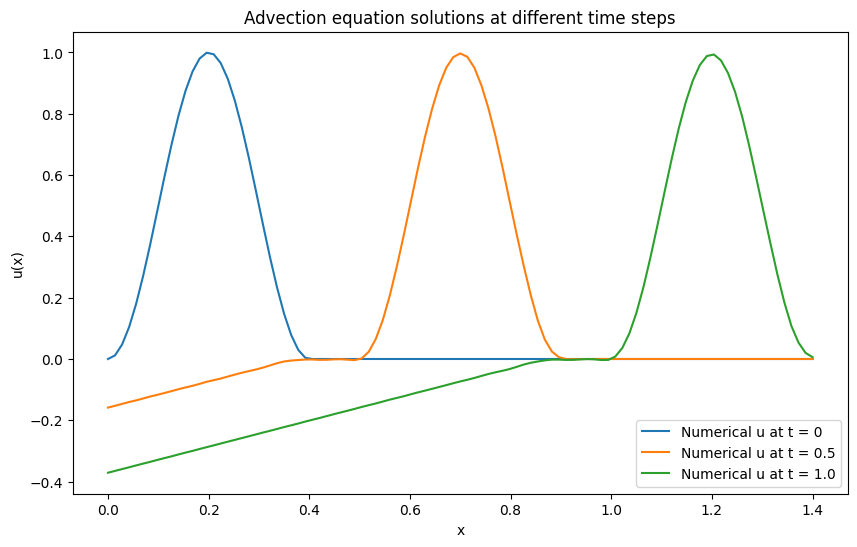

In [30]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total simulation time
dt = 0.0001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed
L = 1.4  # Domain length

# Step 1: Create a 1D mesh on the interval [0, L] with 100 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, L])

# Step 2: Define function space (Lagrange elements of degree 1)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition
u_n = fem.Function(V)
def initial_condition(x):
    values = np.zeros_like(x[0])
    mask = x[0] < 0.4
    values[mask] = 0.5 * (1 + np.cos(5 * np.pi * (x[0][mask] - 0.2)))
    return values

u_n.interpolate(initial_condition)

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# Step 6: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L)

# Step 7: Time-stepping loop
times_to_store = [0, 0.5, 1.0]  # Times to store solutions
stored_solutions = {}

for n in range(num_steps + 1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store solution at specific times
    current_time = n * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 8: Plot numerical solutions at different time steps
mesh_points = V.tabulate_dof_coordinates()[:, 0]

plt.figure(figsize=(10, 6))
for time in times_to_store:
    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]
    plt.plot(mesh_points, u_fenics, label=f"Numerical u at t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()

## With BC

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1.4], \, t \in [0, 1]$

The boundary and initial conditions are:

$u(0, t) = 0 \quad \forall \, t$

$u(x, 0) = 
\begin{cases} 
\frac{1 + \cos\left( 5\pi (x - 0.2) \right)}{2}, & \text{if} \, x < 0.4 \\
0, & \text{else}.
\end{cases}$


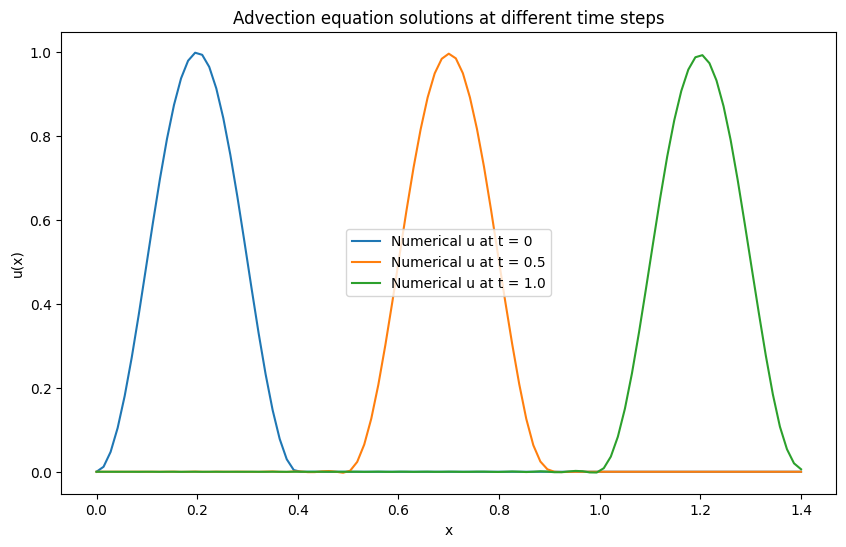

In [31]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
from petsc4py import PETSc
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total simulation time
dt = 0.0001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed
L = 1.4  # Domain length

# Step 1: Create a 1D mesh on the interval [0, L] with 100 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, L])

# Step 2: Define function space (Lagrange elements of degree 1)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition
u_n = fem.Function(V)
def initial_condition(x):
    values = np.zeros_like(x[0])
    mask = x[0] < 0.4
    values[mask] = 0.5 * (1 + np.cos(5 * np.pi * (x[0][mask] - 0.2)))
    return values

u_n.interpolate(initial_condition)

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# Step 6: Define Dirichlet boundary condition u(0,t) = 0
def boundary_left(x):
    return np.isclose(x[0], 0.0)  # Mark the boundary at x=0

# boundary_left([0.0])  # x[0] = 0.0
# np.isclose(0.0, 0.0) -> True

u_D = fem.Function(V)  # Dirichlet condition is zero
bc = fem.dirichletbc(u_D, fem.locate_dofs_geometrical(V, boundary_left))

# Step 7: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L, bcs=[bc])  # Apply the boundary condition

# Store solutions for desired time steps
times_to_store = [0, 0.5, 1.0]  # Times to store solutions
stored_solutions = {}

for n in range(num_steps + 1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store solution at specific times
    current_time = n * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0):
        # print(u_n.x.array)
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 8: Plot numerical solutions at different time steps
mesh_points = V.tabulate_dof_coordinates()[:, 0]

plt.figure(figsize=(10, 6))
for time in times_to_store:
    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]
    plt.plot(mesh_points, u_fenics, label=f"Numerical u at t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()

## Comparing numerical solution with analytical solution

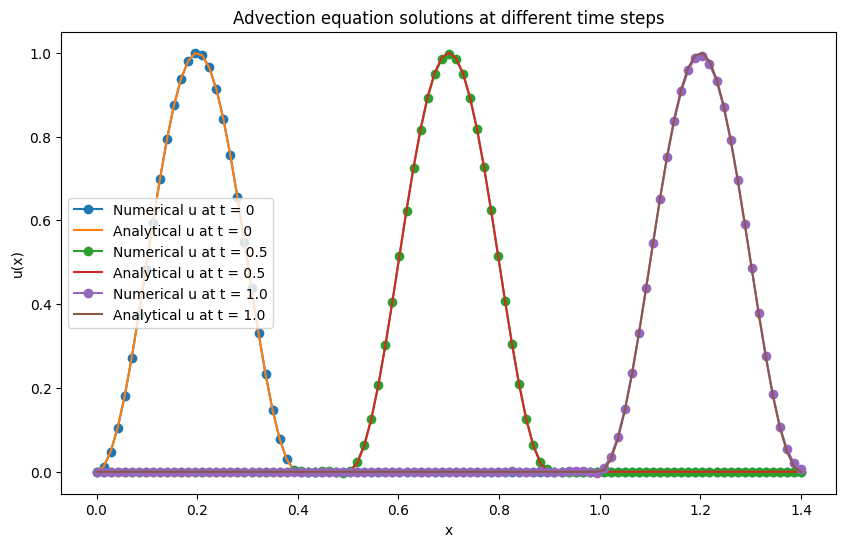

In [33]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
from petsc4py import PETSc
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total simulation time
dt = 0.0001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed
L = 1.4  # Domain length

# Step 1: Create a 1D mesh on the interval [0, L] with 100 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, L])

# Step 2: Define function space (Lagrange elements of degree 1)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition
u_n = fem.Function(V)
def initial_condition(x):
    values = np.zeros_like(x[0])
    mask = x[0] < 0.4
    values[mask] = 0.5 * (1 + np.cos(5 * np.pi * (x[0][mask] - 0.2)))
    return values

u_n.interpolate(initial_condition)

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# Step 6: Define Dirichlet boundary condition u(0,t) = 0
def boundary_left(x):
    return np.isclose(x[0], 0.0)  # Mark the boundary at x=0

u_D = fem.Function(V)  # Dirichlet condition is zero
bc = fem.dirichletbc(u_D, fem.locate_dofs_geometrical(V, boundary_left))

# Step 7: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L, bcs=[bc])  # Apply the boundary condition

# Store solutions for desired time steps
times_to_store = [0, 0.5, 1.0]  # Times to store solutions
# times_to_store = [1]  # Times to store solutions
stored_solutions = {}

for n in range(num_steps + 1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store solution at specific times
    current_time = n * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0):
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 8: Plot numerical solutions at different time steps
mesh_points = V.tabulate_dof_coordinates()[:, 0]


def analytical_solution(x, t, c):
    u_analytical = np.zeros_like(x)
    wavefront = c * t  # Position of the wavefront at time t
    mask = (x >= 0.0 + wavefront) & (x <= 0.4 + wavefront)  # extracting the positions of x where analytical 
                                                            # solution is present for a given time step t
    u_analytical[mask] = 0.5 * (1 + np.cos(5 * np.pi * (x[mask] - wavefront - 0.2)))
    return u_analytical

plt.figure(figsize=(10, 6))
for time in times_to_store:
    # Analytical solution at this time step
    u_analytical = analytical_solution(mesh_points, time, c)
    
    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]
    plt.plot(mesh_points, u_fenics, marker = 'o', label=f"Numerical u at t = {time}")
    plt.plot(mesh_points, u_analytical, linestyle="solid", label=f"Analytical u at t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()


## A non zero BC solution

$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \quad \text{for} \quad x \in [0, 1.4], \, t \in [0, 1]$

The boundary and initial conditions are:

$u(0, t) = 0.2 \quad \forall \, t$

$u(x, 0) = 
\begin{cases} 
\frac{1 + \cos\left( 5\pi (x - 0.2) \right)}{2}, & \text{if} \, x < 0.4 \\
0, & \text{else}.
\end{cases}$


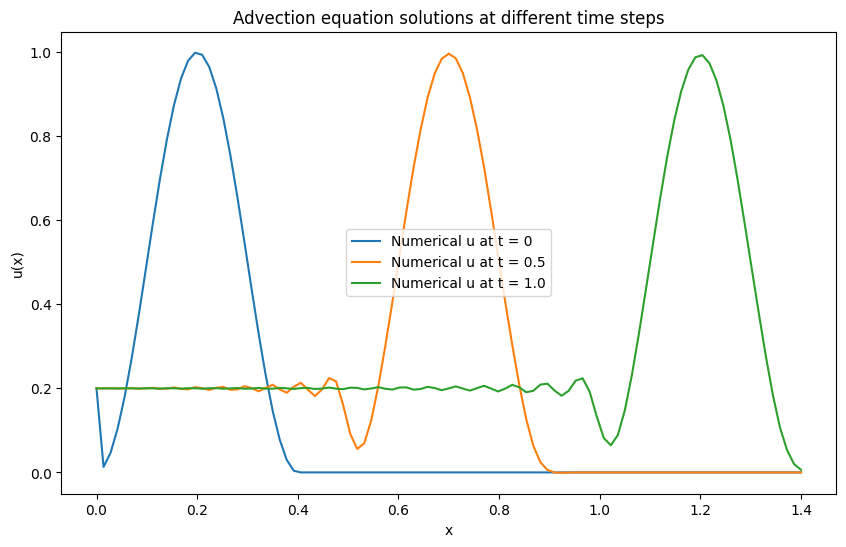

In [32]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from ufl import TrialFunction, TestFunction, inner, grad, dx
from dolfinx.fem.petsc import LinearProblem
from petsc4py import PETSc
import matplotlib.pyplot as plt

# Parameters
T = 1.0  # Total simulation time
dt = 0.0001  # Time step size
num_steps = int(T / dt)  # Number of time steps
c = 1.0  # Advection speed
L = 1.4  # Domain length

# Step 1: Create a 1D mesh on the interval [0, L] with 100 elements
domain = mesh.create_interval(MPI.COMM_WORLD, 100, [0, L])

# Step 2: Define function space (Lagrange elements of degree 1)
V = fem.functionspace(domain, ("Lagrange", 1))

# Step 3: Define initial condition
u_n = fem.Function(V)
def initial_condition(x):
    values = np.zeros_like(x[0])
    mask = x[0] < 0.4
    values[mask] = 0.5 * (1 + np.cos(5 * np.pi * (x[0][mask] - 0.2)))
    # print(values)
    values[np.isclose(x[0], 0.0)] = 0.2  # Ensure u(0,0) = 0.2
    # print(values)
    return values

u_n.interpolate(initial_condition)

# Step 4: Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Step 5: Weak form for the advection equation using backward Euler method
a = inner(u, v) * dx + dt * c * inner(grad(u)[0], v) * dx
L = inner(u_n, v) * dx

# Step 6: Define Dirichlet boundary condition u(0,t) = 0
def boundary_left(x):
    return np.isclose(x[0], 0.0)  # Mark the boundary at x=0

# boundary_left([0.0])  # x[0] = 0.0
# np.isclose(0.0, 0.0) -> True

u_D = fem.Function(V)  # Dirichlet condition as a function
u_D.x.array[:] = 0.2  # Set the boundary value to 0.2
# print(u_D.x.array)

# u_D = fem.Function(V)  # Dirichlet condition is zero
bc = fem.dirichletbc(u_D, fem.locate_dofs_geometrical(V, boundary_left))

# Step 7: Time-stepping loop
u_new = fem.Function(V)  # Solution at the new time step
problem = LinearProblem(a, L, bcs=[bc])  # Apply the boundary condition

# Store solutions for desired time steps
times_to_store = [0, 0.5, 1.0]  # Times to store solutions
stored_solutions = {}

for n in range(num_steps + 1):
    # Solve the linear system for u at the new time step
    u_new = problem.solve()

    # Update the solution for the next time step
    u_n.x.array[:] = u_new.x.array[:]

    # Store solution at specific times
    current_time = n * dt
    if np.isclose(current_time, 0.0) or np.isclose(current_time, 0.5) or np.isclose(current_time, 1.0):
        # print(u_n.x.array)
        stored_solutions[current_time] = u_n.x.array.copy()

# Step 8: Plot numerical solutions at different time steps
mesh_points = V.tabulate_dof_coordinates()[:, 0]

plt.figure(figsize=(10, 6))
for time in times_to_store:
    # FEniCS solution stored at this time step
    u_fenics = stored_solutions[time]
    plt.plot(mesh_points, u_fenics, label=f"Numerical u at t = {time}")

# Final plot configurations
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(f"Advection equation solutions at different time steps")
plt.show()